In [504]:
import numpy as np

# two d=3 qudits

In [505]:
n_qudits = 2
d = 3

### Generate "unkown" state you want to learn

In [506]:
def random_complex_vector(n):
    # Generate random real and imaginary parts
    real_part = np.random.uniform(low=-1, high=1, size=n)
    imag_part = np.random.uniform(low=-1, high=1, size=n)
    
    # Combine them to form a complex vector
    vector = real_part + 1j * imag_part
    
    # Normalize the vector to have norm = 1
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    
    return normalized_vector

psi = random_complex_vector(d**n_qudits).reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [507]:
smallest_bases = True

if smallest_bases is True:
    basis_states = []

    for i in range(d**n_qudits):
        # Direct measurements of "alpha"
        basis_vector = np.zeros(d**n_qudits, dtype=np.complex128).reshape(-1, 1)
        basis_vector[i] = 1
        basis_states.append(basis_vector)

        if i > 0: # add bases for phase measurements
            basis_vector_plus = np.zeros(d**n_qudits, dtype=np.complex128).reshape(-1, 1)
            basis_vector_plus[0] = 1
            basis_vector_plus[i] = 1
            basis_vector_plus *= 1/np.sqrt(2)

            basis_vector_i = basis_vector_plus.copy()
            basis_vector_i[i] *= 1j

            basis_states.append(basis_vector_plus)
            basis_states.append(basis_vector_i)
else:
    zero = np.array([1, 0, 0]).reshape(-1, 1)
    one = np.array([0, 1, 0]).reshape(-1, 1)
    two = np.array([0, 0, 1]).reshape(-1, 1) 

    plus_zero_one = 1/np.sqrt(2) * np.array([1, 1, 0]).reshape(-1, 1)
    i_zero_one = 1/np.sqrt(2) * np.array([1, 1j, 0]).reshape(-1, 1)

    plus_zero_two = 1/np.sqrt(2) * np.array([1, 0, 1]).reshape(-1, 1)
    i_zero_two = 1/np.sqrt(2) * np.array([1, 0, 1j]).reshape(-1, 1)

    basis_states = [zero, one, two,
                    plus_zero_one, i_zero_one,
                    plus_zero_two, i_zero_two]

### Create measurement projectors

In [508]:
# 2 qubits
if smallest_bases is True:
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qudit_measurement_operators = measurement_operators
else: 
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qudit_measurement_operators = []
    for qubit_1_op in measurement_operators:
        for qubit_2_op in measurement_operators:
            two_qudit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

In [509]:
len(two_qudit_measurement_operators)

25

In [510]:
two_qudit_measurement_operators

[array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [511]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qudit_measurement_operators]

probabilities = get_probabilities(unkown_dm)

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [512]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters. Returns a lower triangular matrix with complex elements below the diagonal
    real elements on the diagonal. """
    T = np.zeros((9, 9), dtype=np.complex_)
    index = 0 
    for i, row in enumerate(T):
        for j in range(len(row)):
            if j < i:
                T[i, j] = t[index] + 1j*t[index + 1]
                index += 2
            elif i == j:
                T[i, j] = t[index]
                index += 1
            else:
                continue

    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [513]:
dm_parameters = np.random.uniform(low=-1, high=1, size=d**n_qudits**2)

In [514]:
parameterized_dm = get_parameterized_dm(dm_parameters)

In [515]:
for row in parameterized_dm:
    print(row)

[ 0.22622509-3.81565836e-19j -0.01866424+5.48745747e-02j
  0.0506802 -5.08726477e-02j  0.04303759+6.08442892e-04j
 -0.0273525 +5.55344345e-02j  0.02410468+3.59762398e-02j
  0.01793044+1.84058823e-02j  0.02013137-5.04451506e-03j
 -0.01097233+3.81057532e-03j]
[-0.01866424-5.48745747e-02j  0.16830288-4.49367299e-19j
  0.02724833-4.51045429e-02j  0.0199816 +4.76504281e-02j
  0.01846606+2.22372823e-02j -0.04949205-1.15916759e-02j
 -0.02515289-6.08994842e-03j  0.039624  -2.18001801e-02j
 -0.01735442+1.76378957e-02j]
[ 0.0506802 +5.08726477e-02j  0.02724833+4.51045429e-02j
  0.18542078+2.77479635e-18j  0.00791213+4.74693239e-02j
 -0.02067145-3.41021127e-02j -0.02310829-1.39926068e-02j
 -0.0052006 +1.36675847e-02j  0.02903424+4.34154166e-02j
 -0.02337101-2.26643481e-02j]
[ 0.04303759-6.08442892e-04j  0.0199816 -4.76504281e-02j
  0.00791213-4.74693239e-02j  0.15235782+8.88722207e-19j
 -0.03546937+5.84013896e-03j  0.03126211+1.57781551e-02j
  0.02706002+1.43685341e-02j  0.01293128+1.02949944e-02

### Test that DM is valid

In [516]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [517]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [518]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [519]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [520]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

# Density Matrix Fidelity: "Unknown" DM vs. Reconstructed DM

In [521]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

print("Density matrix fidelity:", dm_fidelity(unkown_dm, found_dm))

Density matrix fidelity: 0.989970126290511


### Plot Density Matrices

In [522]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [523]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

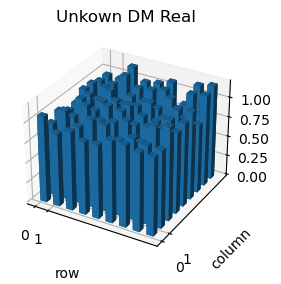

[[1.07814642 0.91297784 0.9877304  0.91168334 0.9226148  1.02456265
  1.02124949 0.9786073  0.97569055]
 [0.91297784 1.11493584 0.96252213 1.10293414 1.07976941 0.93771414
  1.0175199  0.97909177 0.97003834]
 [0.9877304  0.96252213 1.14698619 1.00085664 1.03031787 1.09523093
  0.87984988 1.13023587 1.16558649]
 [0.91168334 1.10293414 1.00085664 1.10097729 1.08582699 0.96335397
  0.98646154 1.01279778 1.01296476]
 [0.9226148  1.07976941 1.03031787 1.08582699 1.07890679 0.98808667
  0.96432734 1.03707484 1.04433325]
 [1.02456265 0.93771414 1.09523093 0.96335397 0.98808667 1.07540511
  0.92688586 1.07994314 1.10286085]
 [1.02124949 1.0175199  0.87984988 0.98646154 0.96432734 0.92688586
  1.09984599 0.89201132 0.86311982]
 [0.9786073  0.97909177 1.13023587 1.01279778 1.03707484 1.07994314
  0.89201132 1.11682975 1.14814721]
 [0.97569055 0.97003834 1.16558649 1.01296476 1.04433325 1.10286085
  0.86311982 1.14814721 1.18796662]]


In [524]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

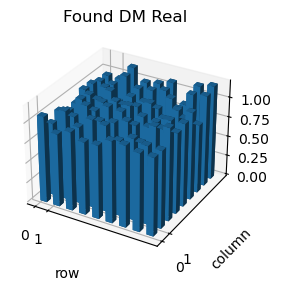

[[1.07866667 0.91290961 0.98743791 0.91157487 0.92242048 1.02417806
  1.02091208 0.97845652 0.97507315]
 [0.91290961 1.1146313  0.96354398 1.10248401 1.07968542 0.93901705
  1.01788077 0.97960291 0.97141612]
 [0.98743791 0.96354398 1.14706984 1.00140537 1.03011836 1.09416057
  0.88116837 1.1289983  1.16122514]
 [0.91157487 1.10248401 1.00140537 1.10069649 1.08563364 0.96398146
  0.98696209 1.01316578 1.01347842]
 [0.92242048 1.07968542 1.03011836 1.08563364 1.07879048 0.98827576
  0.96493089 1.03655473 1.04467929]
 [1.02417806 0.93901705 1.09416057 0.96398146 0.98827576 1.07542369
  0.92787314 1.07830515 1.10036228]
 [1.02091208 1.01788077 0.88116837 0.98696209 0.96493089 0.92787314
  1.09972499 0.89322286 0.86397324]
 [0.97845652 0.97960291 1.1289983  1.01316578 1.03655473 1.07830515
  0.89322286 1.11678847 1.14339968]
 [0.97507315 0.97141612 1.16122514 1.01347842 1.04467929 1.10036228
  0.86397324 1.14339968 1.18820806]]


In [525]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

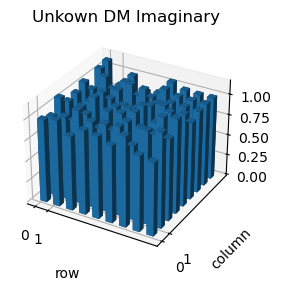

[[1.         1.03753622 0.89352981 1.00954884 0.98666531 0.92727232
  1.08573836 0.90687547 0.88126514]
 [0.96246378 1.         1.12445638 1.03178793 1.05201981 1.06918975
  0.89431681 1.11397707 1.14389719]
 [1.10647019 0.87554362 1.         0.87817417 0.89666058 1.04488407
  1.01548966 0.9854749  0.98552201]
 [0.99045116 0.96821207 1.12182583 1.         1.02452594 1.07919136
  0.90050684 1.10785809 1.13715785]
 [1.01333469 0.94798019 1.10333942 0.97547406 1.         1.07621055
  0.91872277 1.08856702 1.11343018]
 [1.07272768 0.93081025 0.95511593 0.92080864 0.92378945 1.
  1.04672494 0.95082018 0.94005595]
 [0.91426164 1.10568319 0.98451034 1.09949316 1.08127723 0.95327506
  1.         0.99814869 0.99438487]
 [1.09312453 0.88602293 1.0145251  0.89214191 0.91143298 1.04917982
  1.00185131 1.         1.00353507]
 [1.11873486 0.85610281 1.01447799 0.86284215 0.88656982 1.05994405
  1.00561513 0.99646493 1.        ]]


In [526]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

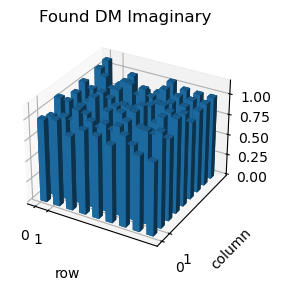

[[1.         1.03748169 0.89425461 1.00953348 0.98681976 0.9277776
  1.08591983 0.90743007 0.88205906]
 [0.96251831 1.         1.12332463 1.03165368 1.05147634 1.06828374
  0.89495372 1.1135148  1.14153898]
 [1.10574539 0.87667537 1.         0.87931236 0.89785636 1.04397118
  1.01368492 0.98619318 0.98629125]
 [0.99046652 0.96834632 1.12068764 1.         1.02417775 1.07855057
  0.90092623 1.10691952 1.1353045 ]
 [1.01318024 0.94852366 1.10214364 0.97582225 1.         1.0753667
  0.91882368 1.087842   1.11193213]
 [1.0722224  0.93171626 0.95602882 0.92144943 0.9246333  1.
  1.04552579 0.95213947 0.94049417]
 [0.91408017 1.10504628 0.98631508 1.09907377 1.08117632 0.95447421
  1.         0.99927585 0.99536617]
 [1.09256993 0.8864852  1.01380682 0.89308048 0.912158   1.04786053
  1.00072415 1.         1.00351992]
 [1.11794094 0.85846102 1.01370875 0.8646955  0.88806787 1.05950583
  1.00463383 0.99648008 1.        ]]


In [527]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [528]:
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [529]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[ 0.23170783+0.1563902j ]
 [-0.18290564-0.28544942j]
 [-0.24945297+0.29113468j]
 [-0.24275353-0.20505613j]
 [-0.25613679-0.11532882j]
 [-0.07271656+0.26479692j]
 [ 0.23458928-0.21169286j]
 [-0.24979547+0.2333066j ]
 [-0.30969635+0.30340532j]]
prob_0 [0.07814642]
prob_1 [0.11493584]


#### original psi from density matrix, testing that it matches psi

In [530]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original_psi_from_dm [ 0.2795468 +0.j         -0.31129729-0.13427525j -0.04389103+0.38086712j
 -0.315928  -0.03415829j -0.27682376+0.04770111j  0.08786595+0.2601628j
  0.07601405-0.30670484j -0.07652637+0.3331268j  -0.08696022+0.42474056j]
prob_0 0.07814641512887066
prob_1 0.11493584480950282


#### statevector from reconstructed dm

In [531]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

found_psi_from_dm [ 0.28175453+0.j         -0.31195744-0.13430738j -0.04584699+0.3799221j
 -0.31692869-0.03415087j -0.27788201+0.04728235j  0.08671546+0.25929075j
  0.07476874-0.30796409j -0.07733435+0.33194283j -0.08870543+0.42253143j]
prob_0 0.07938561377136942
prob_1 0.11535591886868553


### State vector fidelity

In [532]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [533]:
statevector_fidelity(psi, found_psi_from_dm)

0.9999759913378211